In [1]:
import csv
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tensorflow as tf
import tensorflow_probability as tfp
import warnings

from tensorflow_probability import edward2 as ed


In [2]:
url = ('https://raw.github.com/vincentarelbundock/Rdatasets/master/csv/'
         'lme4/InstEval.csv')
 

In [3]:
with requests.Session() as s:
    download = s.get(url)
    f = download.content.decode().splitlines()

In [4]:
iterator = csv.reader(f)
columns = next(iterator)[1:]
x_train = np.array([row[1:] for row in iterator], dtype=np.int)

In [5]:
metadata = {"columns": columns}

In [6]:
data = pd.DataFrame(x_train, columns=metadata['columns'])
data = data.rename(columns={'s': 'students',
                            'd': 'instructors',
                            'dept': 'departments',
                            'y': 'ratings'})


In [7]:
data['instructors'] = data['instructors'].astype('category').cat.codes
data['departments'] = data['departments'].astype('category').cat.codes

In [8]:
train = data.sample(frac=0.8)
test = data.drop(train.index)

train.head()

,students,instructors,studage,lectage,service,departments,ratings
48457,1953,637,4,3,0,0,1
59177,2398,938,2,1,1,10,1
37621,1532,58,4,1,1,7,5
59114,2395,305,4,2,1,10,1
22440,906,900,4,3,1,10,4


In [9]:
get_value = lambda dataframe, key, dtype: dataframe[key].values.astype(dtype)

features_train = {
    k: get_value(train, key=k, dtype=np.int32)
    for k in ['students', 'instructors', 'departments', 'service']
}

labels_train = get_value(train, key="ratings", dtype=np.int32)

features_test = {
    k: get_value(test, key=k, dtype=np.int32)
    for k in ['students', 'instructors', 'departments', 'service']
}

labels_test = get_value(test, key='ratings', dtype=np.float32)

In [10]:
num_students = features_train['students'].max() + 1
num_instructors = features_train['instructors'].max() + 1
num_departments = features_train['departments'].max() + 1
num_observations = train.shape[0]

print("Number of students:", num_students)
print("Number of instructors:", num_instructors)
print("Number of departments:", num_departments)
print("Number of observations:", num_observations)


Number of students: 2973
Number of instructors: 1128
Number of departments: 14
Number of observations: 58737


For our dataset ($N \times D$).
We're going to make a mixed effects model of the form:

$$
y = X\beta + Z\eta + \alpha + \epsilon
$$

Where $X$ is $N \times P$, $Z$ is $N \times Q$
and $D = P + Q$.

$\beta$ is a fixed effect, the slope.
$\alpha$ is also a fixed effect, the intercept.
Fixed effects mean that they are held constant across datasets.

The noise term $\epsilon \sim \mathcal{N}(0, \textbf{I})$.

In addition there is a term $Z\eta$.
$Z$ is a features matrix, 
and $\eta$ is a vector of random slopes.
$\eta$ is normally distributed with a variance component $\sigma^2$.
$\eta$ is the latent variable that describes the random effects: 
the effects that vary across the population (although they may be constant across subpopulations).
In particular the random effects $\eta$ have a mean value of ).
The data label's mean is captured by $X\beta + \alpha$.
The random effects component $Z\eta$ captures the variations in the data:
instructor 54 is rated 1.4 points higher than the mean.

In this tutorial we posit the following effects: 

 - Fixed effects: `service`. `service` is a binary covariate corresponding to whether the course belongs to the instructor's main department. No matter how much additional data we collect, it can only take on values 0 and 1.
 - Random effects: `students`, `instructors`, and `departments`. Given more observations from the population of course evaluation ratings, we may be looking at new students, teachers, or departments.
 


In [16]:
def linear_mixed_effects_model(features):
  # Set up fixed effects and other parameters.
  intercept = tf.get_variable("intercept", [])  # alpha in eq
  effect_service = tf.get_variable("effect_service", [])  # beta in eq
  stddev_students = tf.exp(
      tf.get_variable("stddev_unconstrained_students", []))  # sigma in eq
  stddev_instructors = tf.exp(
      tf.get_variable("stddev_unconstrained_instructors", [])) # sigma in eq
  stddev_departments = tf.exp(
      tf.get_variable("stddev_unconstrained_departments", [])) # sigma in eq

  # Set up random effects.
  effect_students = ed.MultivariateNormalDiag(
      loc=tf.zeros(num_students),
      scale_identity_multiplier=stddev_students,
      name="effect_students")
  effect_instructors = ed.MultivariateNormalDiag(
      loc=tf.zeros(num_instructors),
      scale_identity_multiplier=stddev_instructors,
      name="effect_instructors")
  effect_departments = ed.MultivariateNormalDiag(
      loc=tf.zeros(num_departments),
      scale_identity_multiplier=stddev_departments,
      name="effect_departments")

  # Set up likelihood given fixed and random effects.
  # Note we use `tf.gather` instead of matrix-multiplying a design matrix of
  # one-hot vectors. The latter is memory-intensive if there are many groups.
  ratings = ed.Normal(
      loc=(effect_service * features["service"] +
           tf.gather(effect_students, features["students"]) +
           tf.gather(effect_instructors, features["instructors"]) +
           tf.gather(effect_departments, features["departments"]) +
           intercept),
      scale=1.,
      name="ratings")
  return ratings

# Wrap model in a template. All calls to the model template will use the same
# TensorFlow variables.
model_template = tf.make_template("model", linear_mixed_effects_model)


In [12]:
def strip_consts(graph_def, max_const_size=32):
  """Strip large constant values from graph_def."""
  strip_def = tf.GraphDef()
  for n0 in graph_def.node:
    n = strip_def.node.add()
    n.MergeFrom(n0)
    if n.op == 'Const':
      tensor = n.attr['value'].tensor
      size = len(tensor.tensor_content)
      if size > max_const_size:
        tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
  return strip_def

def draw_graph(model, *args, **kwargs):
  """Visualize TensorFlow graph."""
  graph = tf.Graph()
  with graph.as_default():
    model(*args, **kwargs)
  graph_def = graph.as_graph_def()
  strip_def = strip_consts(graph_def, max_const_size=32)
  code = """
      <script>
        function load() {{
          document.getElementById("{id}").pbtxt = {data};
        }}
      </script>
      <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
      <div style="height:600px">
        <tf-graph-basic id="{id}"></tf-graph-basic>
      </div>
  """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

  iframe = """
      <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
  """.format(code.replace('"', '&quot;'))
  IPython.display.display(IPython.display.HTML(iframe))


draw_graph(linear_mixed_effects_model, features_train)


Instructions for updating:
Colocations handled automatically by placer.


In [17]:
log_joint = ed.make_log_joint_fn(model_template)

def target_log_prob_fn(effect_students, effect_instructors, effect_departments):
  """Unnormalized target density as a function of states."""
  return log_joint(  # fix `features` and `ratings` to the training data
    features=features_train,
    effect_students=effect_students,
    effect_instructors=effect_instructors,
    effect_departments=effect_departments,
    ratings=labels_train)

tf.reset_default_graph()

# Set up E-step (MCMC).
effect_students = tf.get_variable(  # `trainable=False` so unaffected by M-step
    "effect_students", [num_students], trainable=False)
effect_instructors = tf.get_variable(
    "effect_instructors", [num_instructors], trainable=False)
effect_departments = tf.get_variable(
    "effect_departments", [num_departments], trainable=False)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.015,
    num_leapfrog_steps=3)

current_state = [effect_students, effect_instructors, effect_departments]
next_state, kernel_results = hmc.one_step(
      current_state=current_state,
      previous_kernel_results=hmc.bootstrap_results(current_state))

expectation_update = tf.group(
    effect_students.assign(next_state[0]),
    effect_instructors.assign(next_state[1]),
    effect_departments.assign(next_state[2]))

# Set up M-step (gradient descent).
# The following should work. However, TensorFlow raises an error about taking
# gradients through IndexedSlices tensors. This may be a TF bug. For now,
# we recompute the target's log probability at the current state.
# loss = -kernel_results.accepted_results.target_log_prob
with tf.control_dependencies([expectation_update]):
  loss = -target_log_prob_fn(effect_students,
                             effect_instructors,
                             effect_departments)
  optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
  minimization_update = optimizer.minimize(loss)


Instructions for updating:
Use tf.cast instead.


In [18]:
init = tf.global_variables_initializer()

num_warmup_iters = 1000
num_iters = 1500
num_accepted = 0
effect_students_samples = np.zeros([num_iters, num_students])
effect_instructors_samples = np.zeros([num_iters, num_instructors])
effect_departments_samples = np.zeros([num_iters, num_departments])
loss_history = np.zeros([num_iters])

sess = tf.Session()
sess.run(init)

# Run warm-up stage.
for t in range(num_warmup_iters):
  _, is_accepted_val = sess.run(
      [expectation_update, kernel_results.is_accepted])
  num_accepted += is_accepted_val
  if t % 500 == 0 or t == num_warmup_iters - 1:
    print("Warm-Up Iteration: {:>3} Acceptance Rate: {:.3f}".format(
        t, num_accepted / (t + 1)))

num_accepted = 0  # reset acceptance rate counter

# Run training.
for t in range(num_iters):
  for _ in range(5):  # run 5 MCMC iterations before every joint EM update
    _ = sess.run(expectation_update)
  [
      _,
      _,
      effect_students_val,
      effect_instructors_val,
      effect_departments_val,
      is_accepted_val,
      loss_val,
  ] = sess.run([
      expectation_update,
      minimization_update,
      effect_students,
      effect_instructors,
      effect_departments,
      kernel_results.is_accepted,
      loss,
  ])
  effect_students_samples[t, :] = effect_students_val
  effect_instructors_samples[t, :] = effect_instructors_val
  effect_departments_samples[t, :] = effect_departments_val
  num_accepted += is_accepted_val
  loss_history[t] = loss_val
  if t % 500 == 0 or t == num_iters - 1:
    print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(
        t, num_accepted / (t + 1), loss_val))


Warm-Up Iteration:   0 Acceptance Rate: 1.000
Warm-Up Iteration: 500 Acceptance Rate: 0.794
Warm-Up Iteration: 999 Acceptance Rate: 0.755
Iteration:    0 Acceptance Rate: 1.000 Loss: 100924.781
Iteration:  500 Acceptance Rate: 0.663 Loss: 95911.234
Iteration: 1000 Acceptance Rate: 0.679 Loss: 96049.711
Iteration: 1499 Acceptance Rate: 0.683 Loss: 95995.555


Text(0.5, 0, 'iteration')

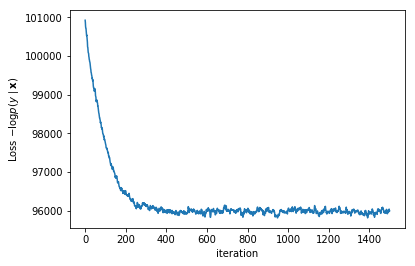

In [23]:
plt.plot(loss_history)
plt.ylabel(r'Loss $-\log p(y \mid \mathbf{x})$')
plt.xlabel("iteration")

Text(0.5, 0, 'Iteration')

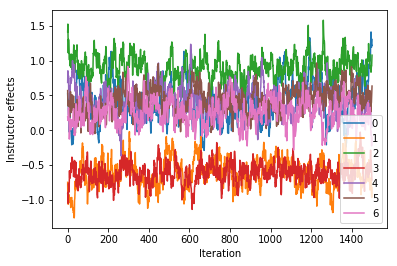

In [25]:
for i in range(7):
    plt.plot(effect_instructors_samples[:, i])
    
plt.legend([i for i in range(7)], loc="lower right")

plt.ylabel("Instructor effects")
plt.xlabel("Iteration")